In [1]:
import pandas as pd
import os
from IPython.display import display,HTML
from ipywidgets import IntProgress

In [2]:
sh_datapath = '/home/liusida/ipython/fund_scanner/data/a_stock/XSHG/'
sz_datapath = '/home/liusida/ipython/fund_scanner/data/a_stock/XSHE/'
pickle_path = '/home/liusida/ipython/fund_scanner/data/a_stock/a_stock_price_total.pickle'
cache_path  = '/home/liusida/ipython/fund_scanner/data/a_stock/cache.pickle'

In [3]:
def read_price_from_files():
    df_price_total = None

    df_filelist_sh = pd.DataFrame(os.listdir( sh_datapath ))
    df_filelist_sh = df_filelist_sh.sort_values(by=0, ascending=True)
    df_filelist_sh = df_filelist_sh[df_filelist_sh[0].str.endswith('.csv')]
    df_filelist_sz = pd.DataFrame(os.listdir( sz_datapath ))
    df_filelist_sz = df_filelist_sz.sort_values(by=0, ascending=True)
    df_filelist_sz = df_filelist_sz[df_filelist_sz[0].str.endswith('.csv')]
    
    pg = IntProgress(min=0, max=min(len(df_filelist_sh)+len(df_filelist_sz),10000), value=0)
    display(pg)

    i=0
    for file in df_filelist_sh.iterrows():
        if i>10000:
            break
        df = pd.read_csv(os.path.join(sh_datapath, file[1][0]), encoding='GBK')
        name = str(df.loc[0,'股票名称'])
        code = df.loc[0,'股票代码'].replace('sh', '')
        column_name = code + '\n' + name
        df_price = df.loc[:,['交易日期','前复权价']]
        df_price['交易日期'] = pd.to_datetime(df_price['交易日期'])
        df_price = df_price.set_index('交易日期')
        df_price.columns = [column_name]
        if df_price_total is None:
            df_price_total = df_price
        else:
            df_price_total = pd.concat([df_price_total, df_price], axis=1)
        i=i+1
        pg.value=i
        pg.description = column_name

    for file in df_filelist_sz.iterrows():
        if i>100000:
            break
        df = pd.read_csv(os.path.join(sz_datapath, file[1][0]), encoding='GBK')
        name = str(df.loc[0,'股票名称'])
        code = df.loc[0,'股票代码'].replace('sz', '')
        column_name = code + '\n' + name
        df_price = df.loc[:,['交易日期','前复权价']]
        df_price['交易日期'] = pd.to_datetime(df_price['交易日期'])
        df_price = df_price.set_index('交易日期')
        df_price.columns = [column_name]
        if df_price_total is None:
            df_price_total = df_price
        else:
            df_price_total = pd.concat([df_price_total, df_price], axis=1)
        i=i+1
        pg.value=i
        pg.description = column_name
        
    df_price_total.to_pickle(pickle_path)
    pg.description = '完成'
    return df_price_total

def read_price_from_pickle():
    df_price_total = pd.read_pickle(pickle_path)
    return df_price_total

In [4]:
df = read_price_from_pickle()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6559 entries, 1990-12-19 to 2017-07-31
Columns: 3401 entries, 600000
浦发银行 to 300681
英搏尔
dtypes: float64(3401)
memory usage: 170.2 MB


In [5]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

m_pca = PCA(n_components=50)
m_tsne = TSNE(n_components=3)
result = m_pca.fit_transform(df.fillna(-1).T)
result = m_tsne.fit_transform(result)

result = pd.DataFrame(result)


In [6]:
result['name'] = df.columns
result.head(2)

,0,1,2,name
0,5.122855,-4.320702,-0.299711,600000\n浦发银行
1,13.105443,-21.064791,10.196558,600001\n邯郸钢铁



fig = plt.figure(figsize=[64,48])
ax = axes3d.Axes3D(fig)
#ax.text3D(result[0], result[1], result[2], result['name'])
pg = IntProgress(min=0, max=len(result), value=0)
display(pg)
for i in range(len(result)):
    f = str(result['name'][i])[0]
    if f=='6':
        bcolor = (1, 0.8, 0.8, 1)
        edgecolor = (0.8, 0.5, 0.5, 1)
    elif f=='3':
        bcolor = (0.8, 1, 0.8, 1)
        edgecolor = (0.5, 0.8, 0.5, 1)
    else:
        bcolor = 'white'
        edgecolor = (0.8, 0.8, 0.8, 1)
    ax.text3D(result[0][i],result[1][i],result[2][i],result['name'][i],
             bbox=dict(facecolor=bcolor, edgecolor=edgecolor, alpha=0.7))
    if i>10000:
        break
    pg.value=i
    
ax.set_xlim(result[0].min(), result[0].max())
ax.set_ylim(result[1].min(), result[1].max())
ax.set_zlim(result[2].min(), result[2].max())
plt.show()


In [11]:
#result.to_pickle(cache_path)
result = pd.read_pickle(cache_path)
result.head(1)

,0,1,2,name
0,1.374276,-4.123345,6.683616,600000\n浦发银行


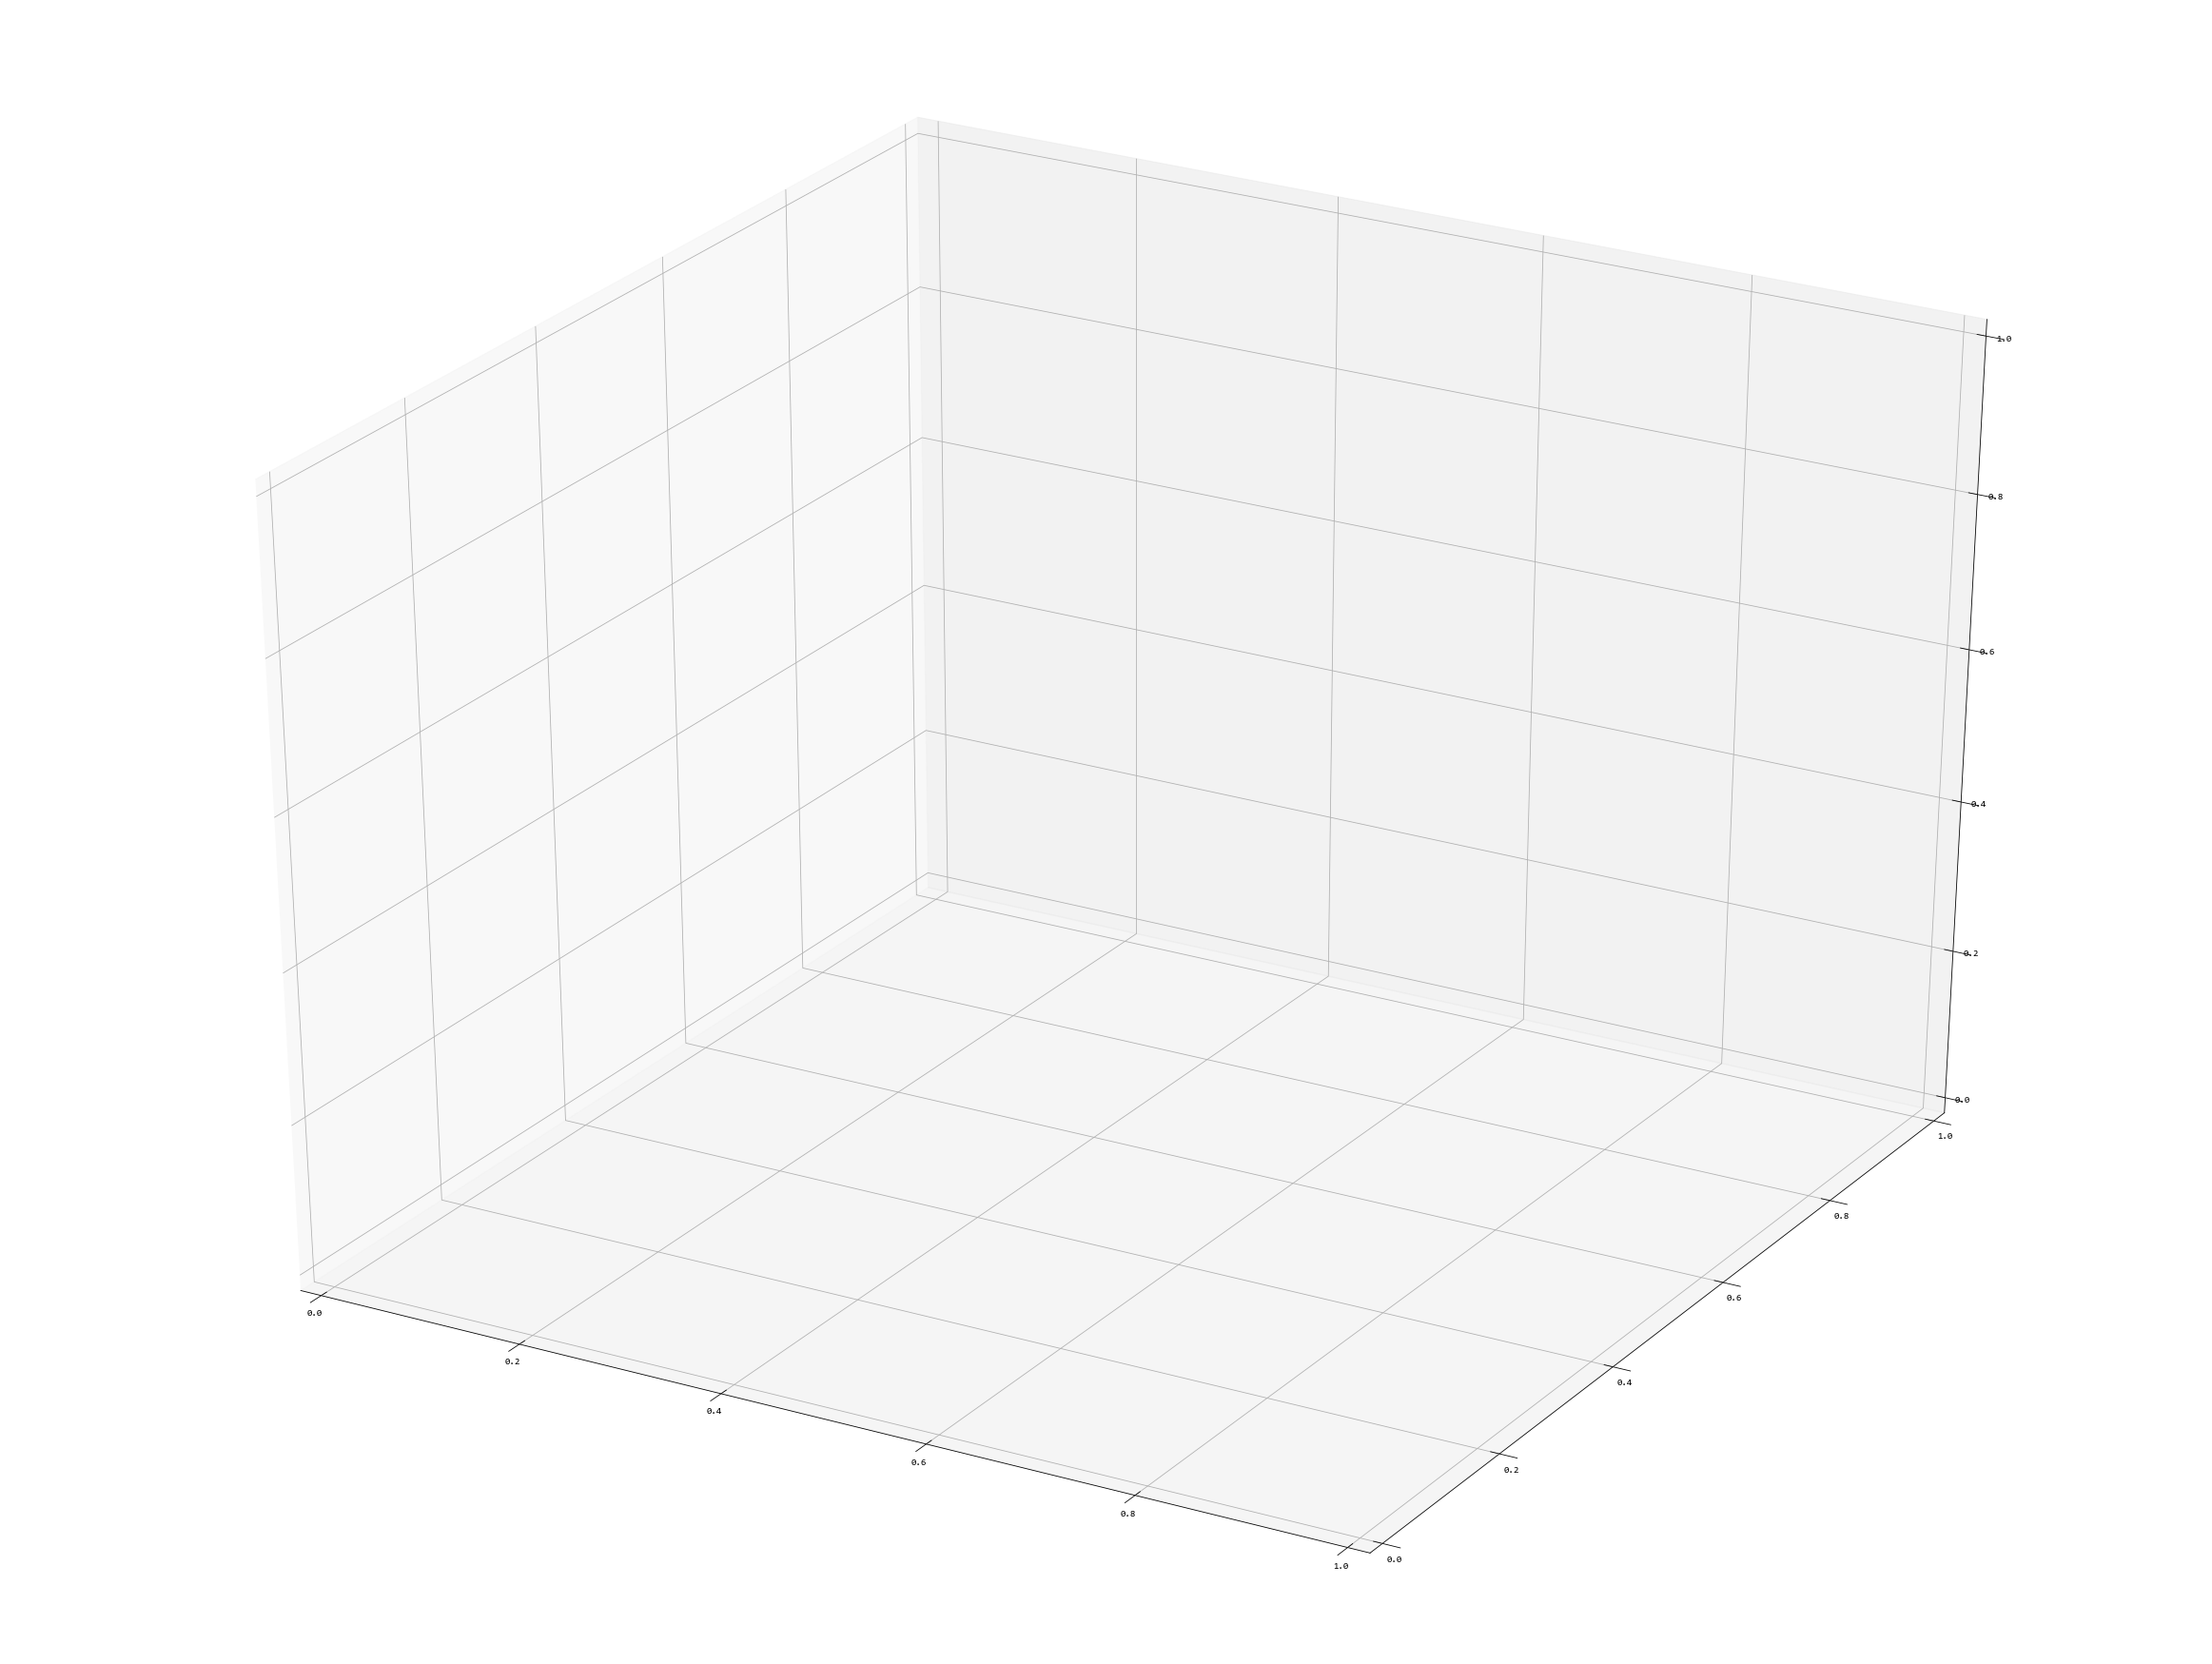

In [24]:
import base
import fund_scanner.animation_framework.framework as fw
from importlib import reload
reload(fw)
#dots = [fw.FWDot(color='blue', pos_x=row[1][0], pos_y=row[1][1], pos_z=row[1][2]) for row in result.head(5).iterrows()]

texts = [fw.FWText(text=row[1]['name'], color='white', pos_x=row[1][0], pos_y=row[1][1], pos_z=row[1][2]) for row in result.iterrows()]

stageArea=[[result[0].min()*1.1, result[0].max()*1.1],
           [result[1].min()*1.1, result[1].max()*1.1],
           [result[2].min()*1.1, result[2].max()*1.1]]
movie = fw.FWMovie(figsize=[32,24], frame_num=5, stageArea=stageArea, movie_length=20000)
movie.add_objects(texts)
movie.display_movie(rotate=True)